# **ARIMA Machine Learning Model for FAANG Securities**
---

### Import Libraries

In [1]:
import os
import warnings

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.dpi'] = 227

warnings.filterwarnings('ignore')

### Import ARIMA, SARIMA Libraries

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import confusion_matrix, accuracy_score

### Import Data

In [3]:
ticker = 'FB'
#ticker = 'AAPL'
#ticker = 'AMZN'
#ticker = 'NFLX'
#ticker = 'GOOG'

# Colors
lightblue = '#4ac2fb'
pinkyred = '#ff4e97'
black='#333333'

In [21]:
files = os.listdir('data/stocks')
stocks = {}
for file in files:
    if file.split('.')[1] == 'csv':
        name = file.split('.')[0]
        stocks[name] = pd.read_csv('data/stocks/'+file, index_col='Date')
        stocks[name].index = pd.to_datetime(stocks[name].index)
        
print(files)

['amzn.csv', 'fb.csv', 'nflx.csv', 'goog.csv', 'aapl.csv']


---
# Baseline Model
- Benchmark for comparing future more complex models
---

In [6]:
def baseline_model(stock):
    
    # turn into 0s and 1s
    Binary = lambda data: [1 if x > 0 else 0 for x in data] 
    
    # .randint(low,high,output size)
    pred = np.random.randint(0,2,len(stock))
    accuracy = accuracy_score(Binary(stock), pred)
    
    return accuracy

In [7]:
baseline_accuracy = baseline_model(stocks[ticker.lower()].Return)
print('Baseline Model Accuracy: {:.1f}%'.format(baseline_accuracy*100))

Baseline Model Accuracy: 50.3%


### Accuracy Distribution

In [8]:
baseline_preds = []
for i in range(1000):
    baseline_preds.append(baseline_model(stocks[ticker.lower()].Return))

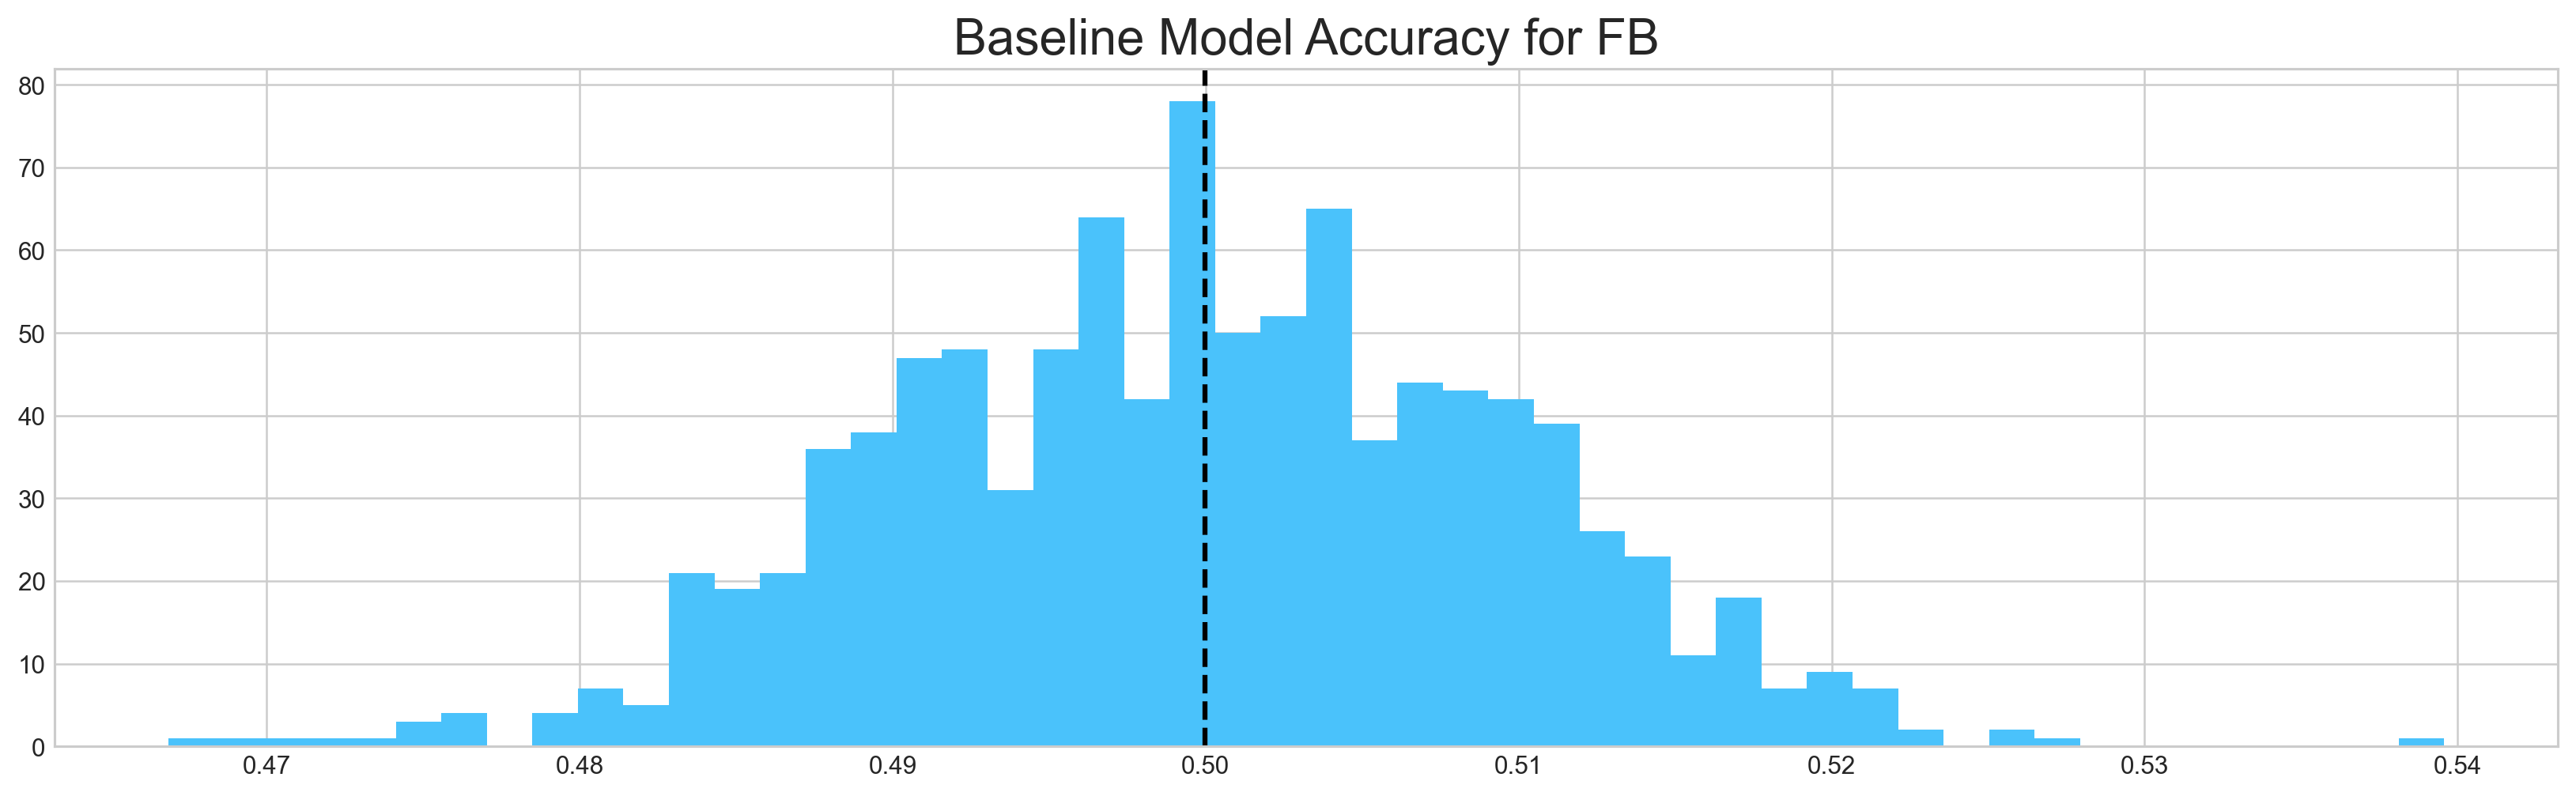

In [9]:
plt.figure(figsize=(18,5))
plt.style.use('seaborn-whitegrid')
plt.hist(baseline_preds, bins=50, facecolor=lightblue)

plt.title(f'Baseline Model Accuracy for {ticker.upper()}', fontsize=20)
plt.axvline(np.array(baseline_preds).mean(), c='k', ls='--', lw=2)
plt.show();

---
# [ARIMA](measurementsUsed/ARIMA.md)
#### AutoRegressive Integrated Moving Averate
- `p` = number of lags in the model
- `d` = degree of differencing -> aka number of times raw observations are differenced
- `q` = order of moving average -> moving average window size 
---

### Split Data for Training and Testing 

In [10]:
all_entries = stocks[ticker.lower()].shape[0]
last_252 = all_entries-253
last_600 = all_entries-600
test_600 = last_600-600
train_600 = test_600-600
print(f'{ticker.upper()} historical data contains {all_entries} entries')

FB historical data contains 2489 entries


In [11]:
test = list(stocks[ticker.lower()]['Return'][test_600:last_600].values)
train = list(stocks[ticker.lower()]['Return'][train_600:test_600].values)

### AutoCorrelation Function
- how time series data points correlate to one another 
- ignore first value -> comparing itself to only itself 

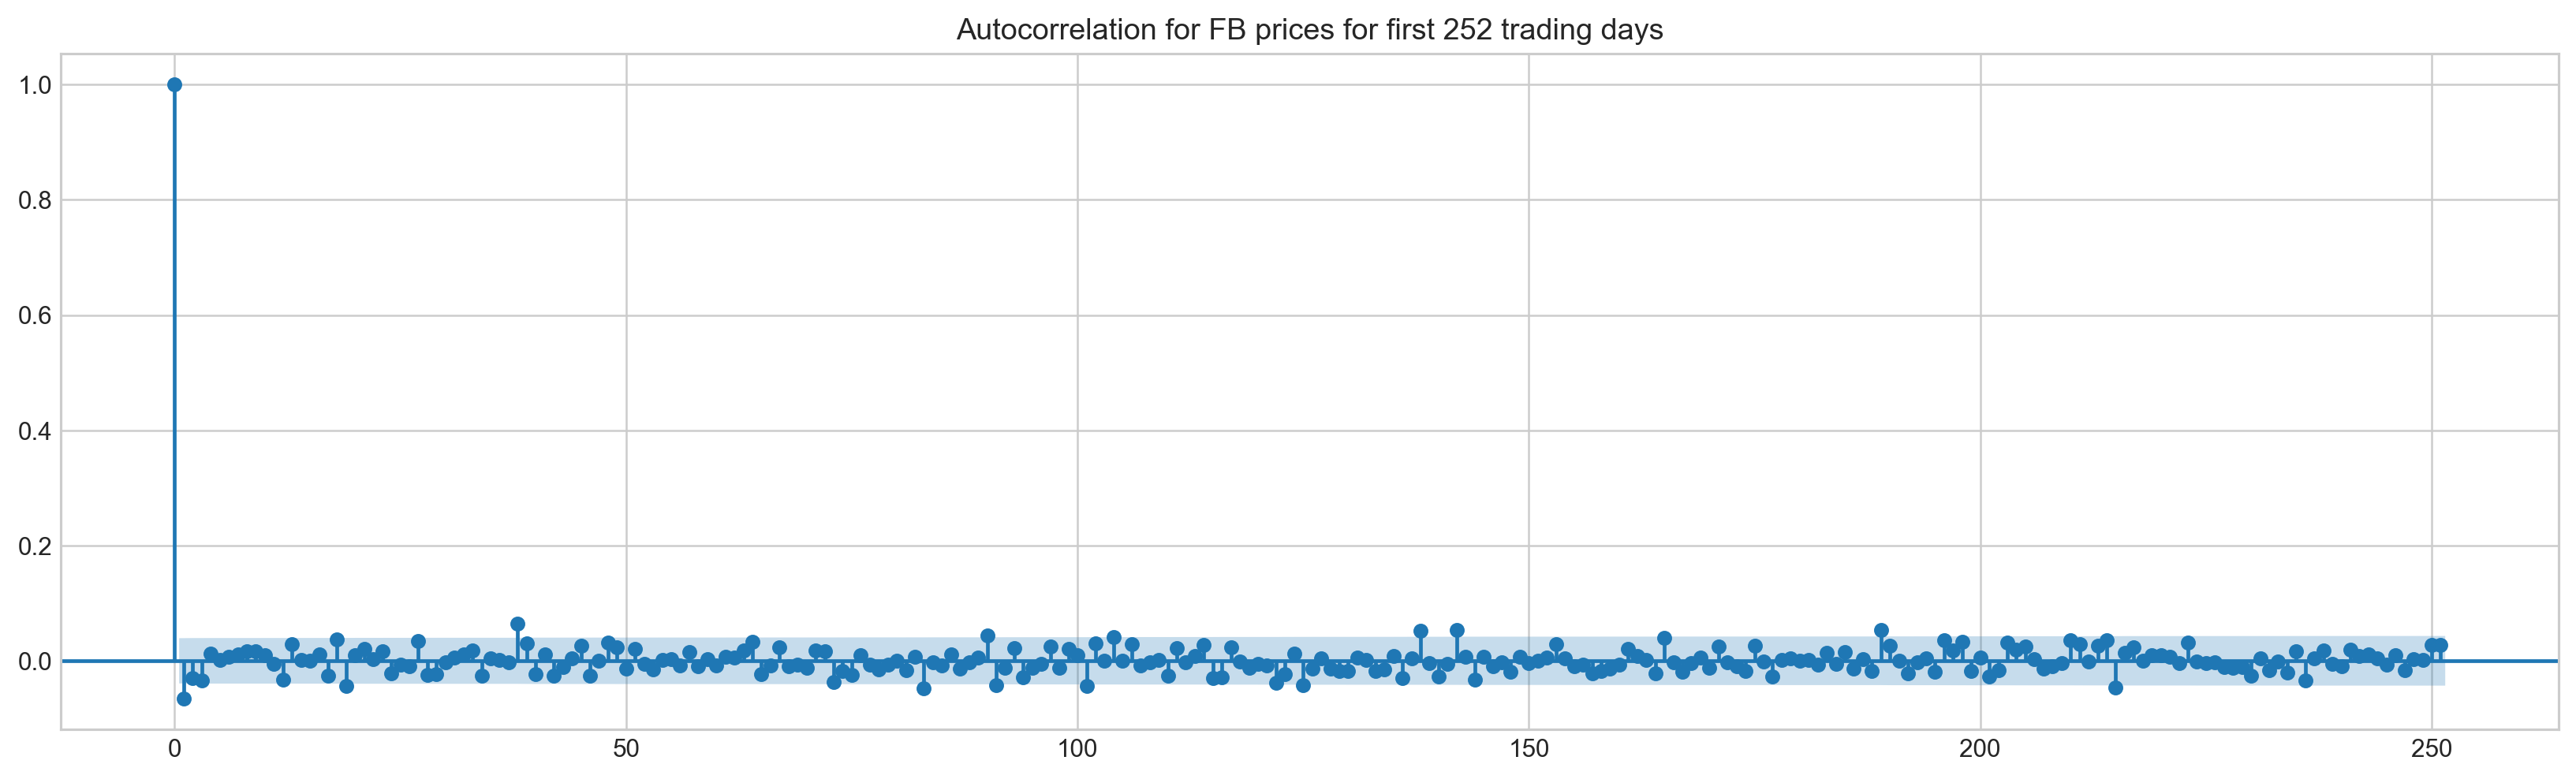

In [12]:
plt.rcParams['figure.figsize'] = (18,5)
plot_acf(stocks[ticker.lower()].Return, lags=range(252))
plt.title(f'Autocorrelation for {ticker.upper()} prices for first 252 trading days')
plt.show()

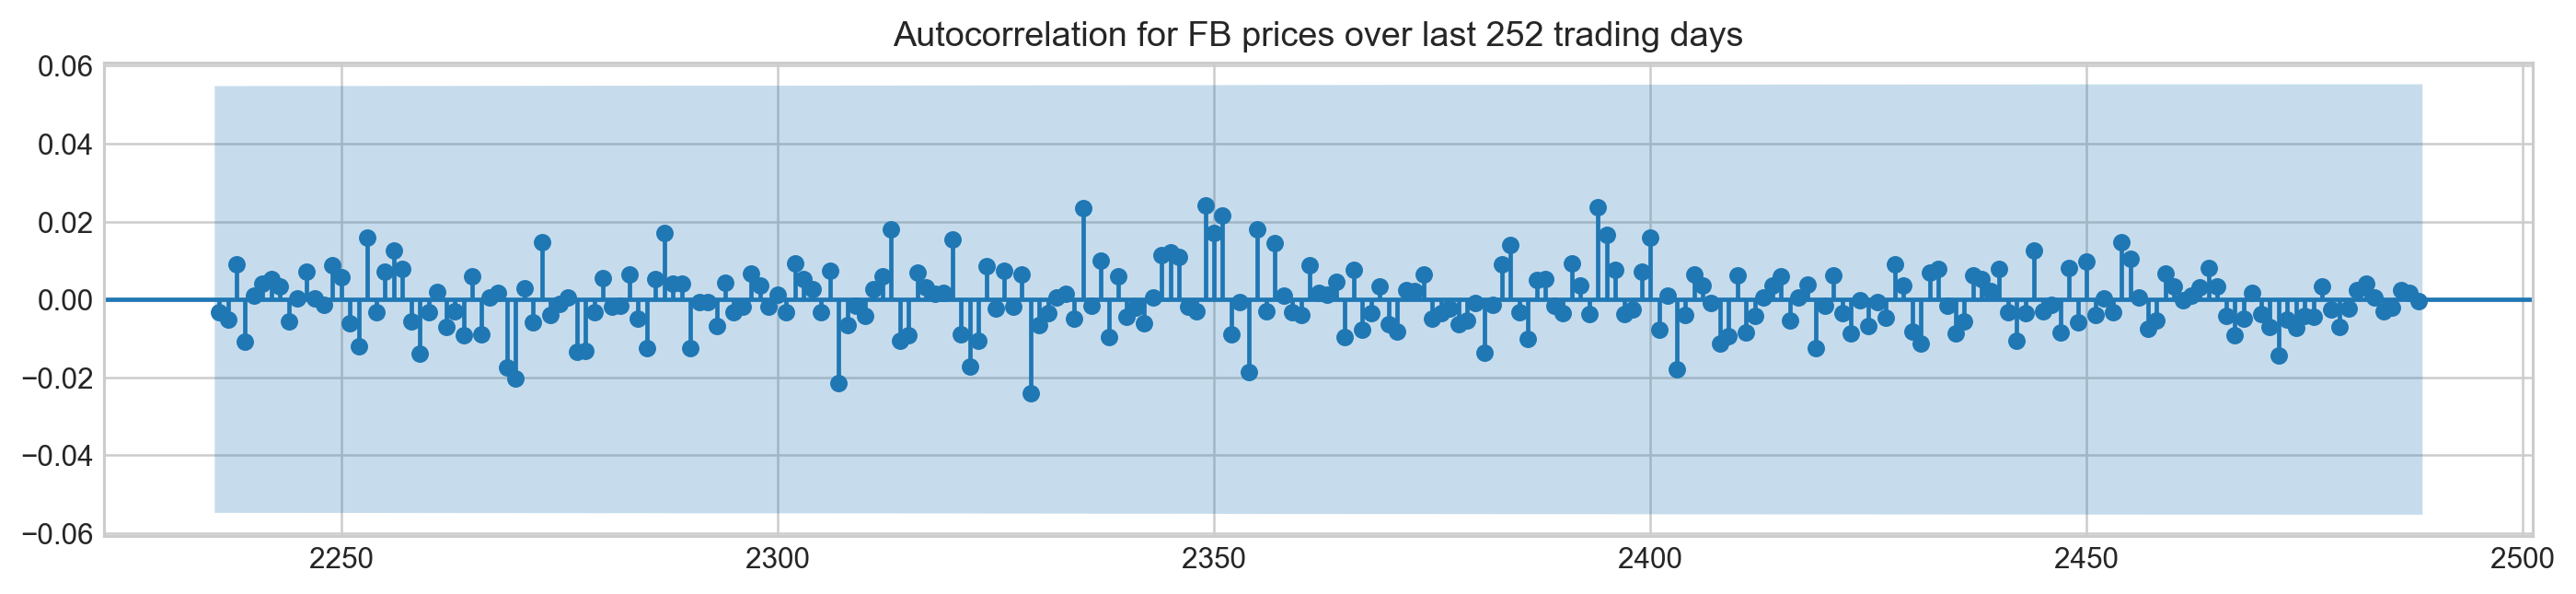

In [13]:
plt.rcParams['figure.figsize'] = (15,3)
plot_acf(stocks[ticker.lower()].Return, lags=range(last_252,all_entries))
plt.title(f'Autocorrelation for {ticker.upper()} prices over last 252 trading days')
plt.show()

#### Make Time Series 'Stationary' by Differencing 
- Differencing: subtract previous value from current value 

In [14]:
# ARIMA Orders
# (p,d,q) -> (lag order, degree of differencing, order of moving average)
orders = [(0,0,0), 
          (1,0,0),
          (0,1,0),
          (0,0,1),
          (1,1,0)]

Binary = lambda data: [1 if x > 0 else 0 for x in data]

In [15]:
all_predictions = {}
accuracy_list = {}

for order in orders:
    try: 
        # shallow copy: new collection object and populating with references to child objects found in the original 
        # a reference of an object is copied in the other object
        # changes do a copy DO REFLECT in the other object 
        history = train.copy() 
        order_predictions = []
    
        for i in range(len(test)):
            model = ARIMA(history, order=order) #(observed time series, order=(p,d,q))
            model_fit = model.fit(disp=0) #trains model using input training and data -> (disp=0) hides data
            y_hat = model_fit.forecast() #predicited value of y (dependent variable) in regression equation  
            order_predictions.append(y_hat[0][0]) #first element the prediction 
            history.append(test[i]) #adding following day's 'return' value to the model 
            print(f"{ticker.upper()} prediction: {i+1} of {len(test)}", end='\r')
    
        # Binary = lambda data: [1 if x > 0 else 0 for x in data]
        accuracy = accuracy_score(Binary(test),
                                   Binary(order_predictions))
        accuracy_list[order] = round(accuracy,3)*100
        print('                       ', end='\r')
        print(f"{order} - {round(accuracy,3)*100}% accuracy", end='\n')
        all_predictions[order] = order_predictions
    
    except:
        print(f"{order} <== Wrong Order", end='\r')
        pass  

/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 0) - 49.5% accuracy
(1, 0, 0) - 52.800000000000004% accuracy


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 0) - 45.800000000000004% accuracy


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 1) - 52.5% accuracy


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0) - 44.2% accuracy


#### Review Predictions on Data

In [16]:
print(accuracy_list)
# print(all_predictions)
best_accuracy = max(accuracy_list.values())
best_order = max(accuracy_list, key=accuracy_list.get)
print(best_accuracy)
print(best_order)

{(0, 0, 0): 49.5, (1, 0, 0): 52.800000000000004, (0, 1, 0): 45.800000000000004, (0, 0, 1): 52.5, (1, 1, 0): 44.2}
52.800000000000004
(1, 0, 0)


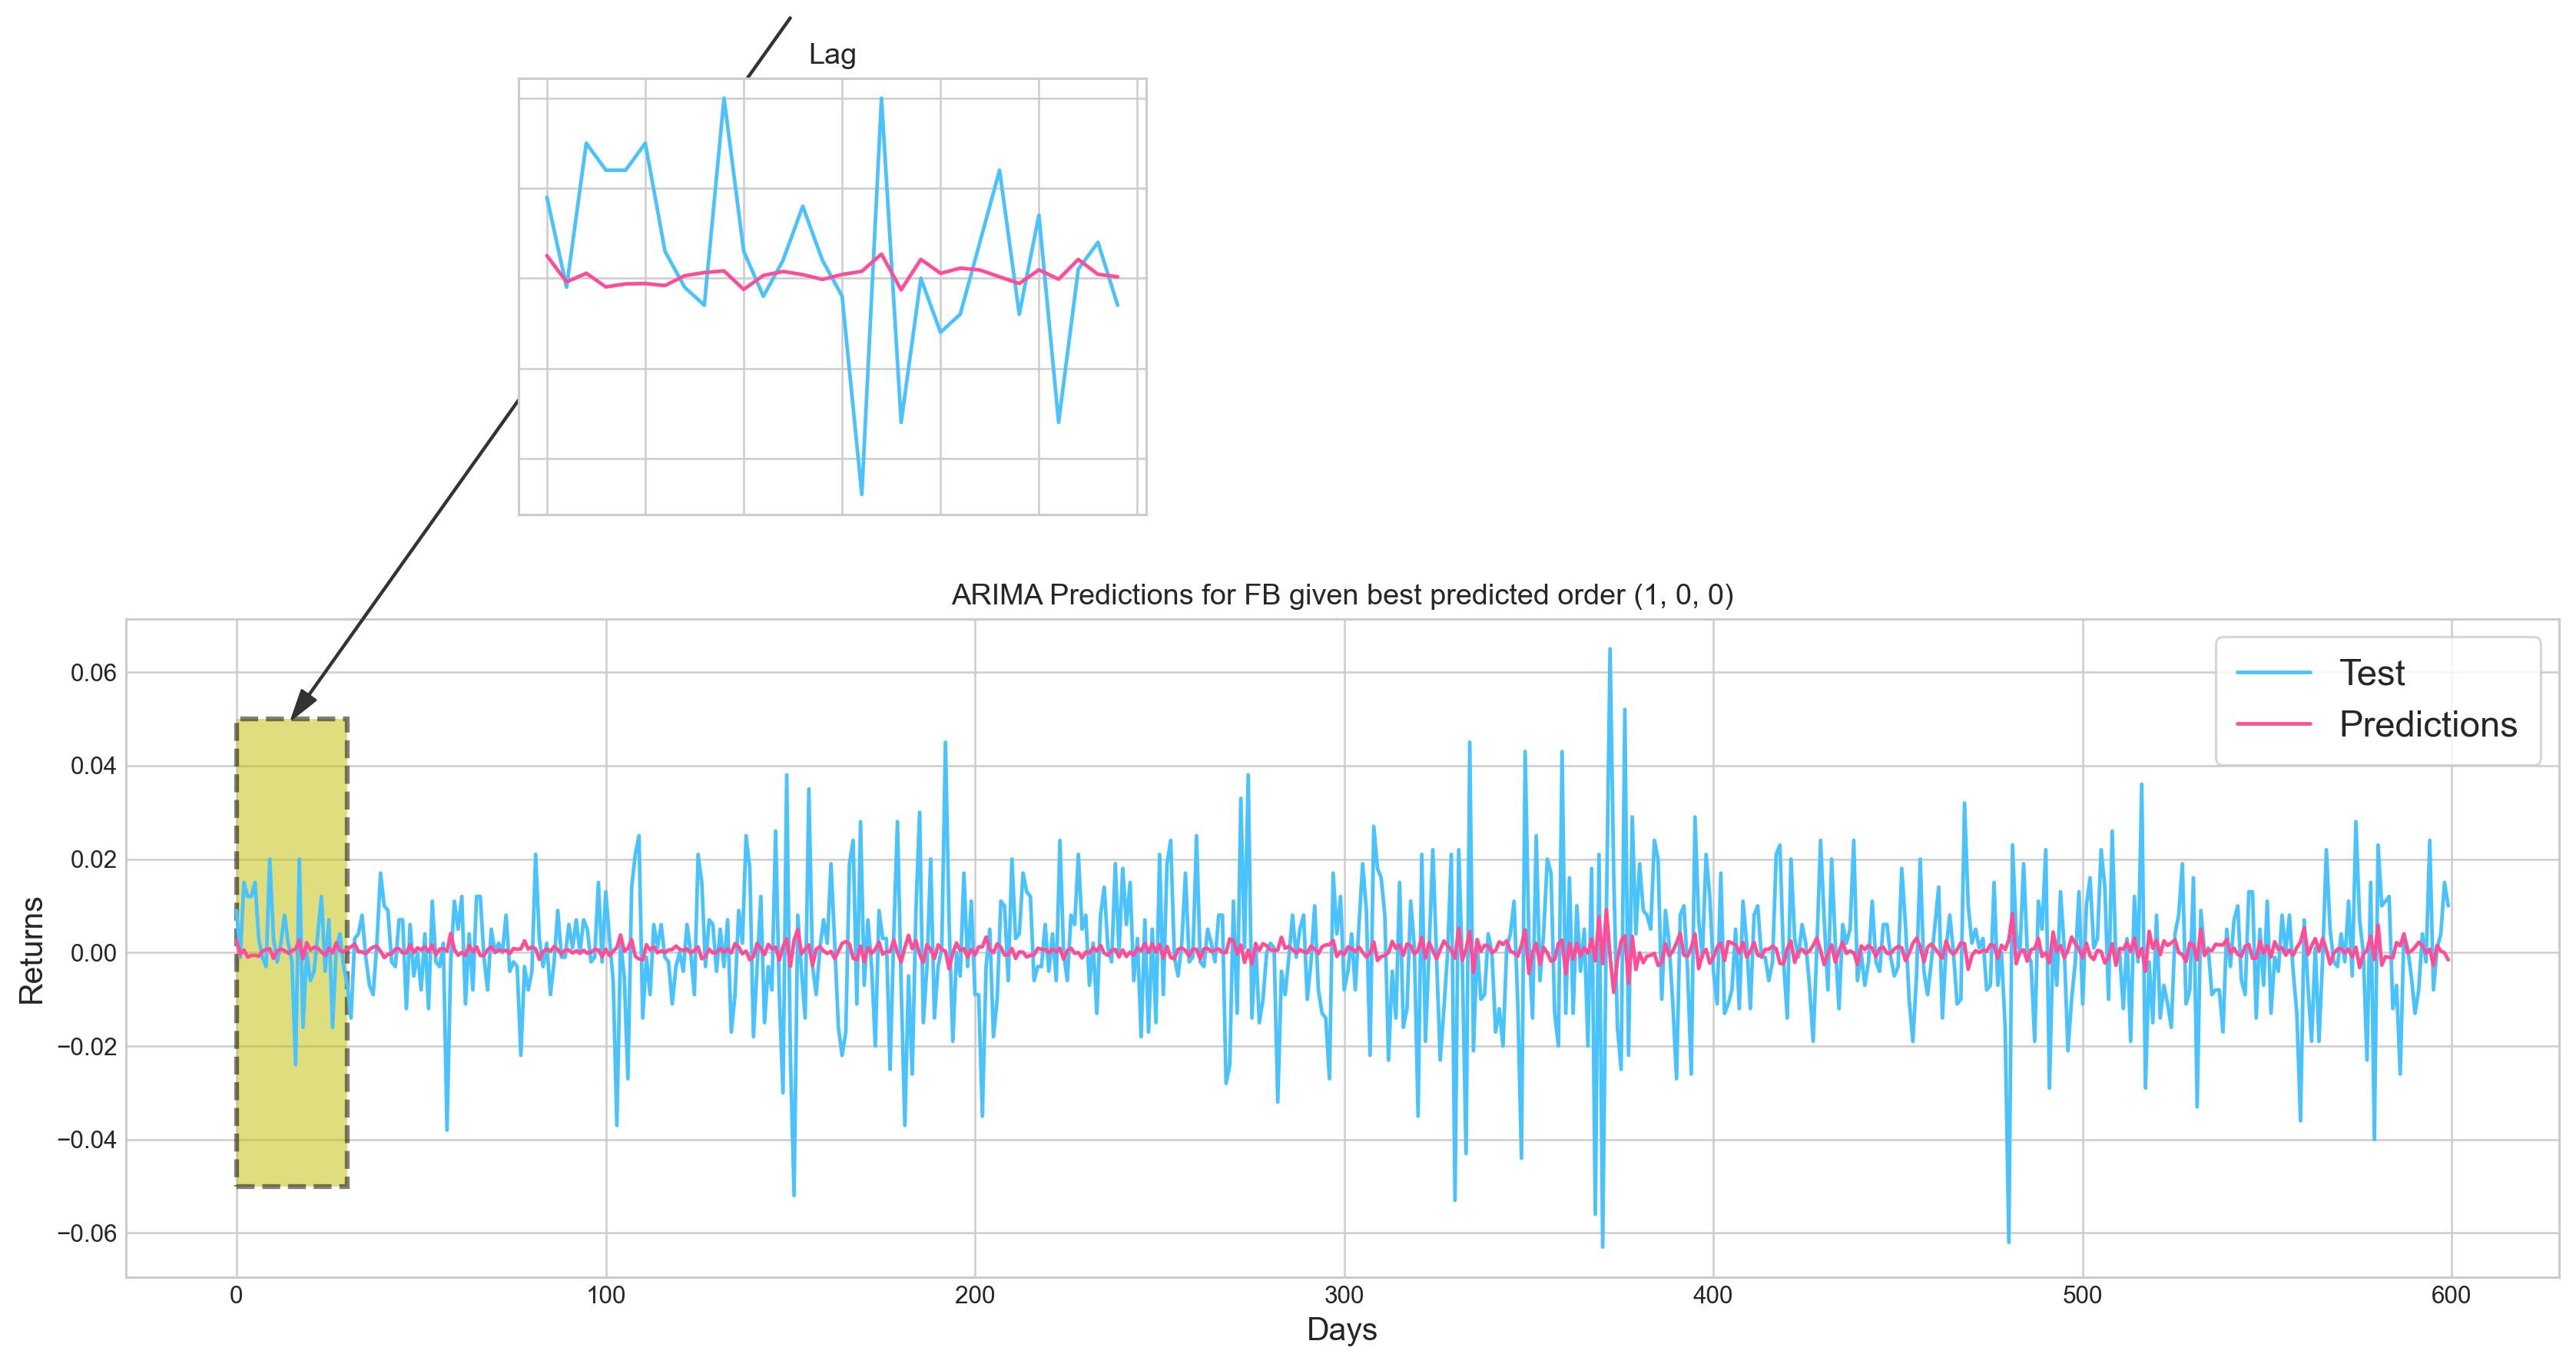

In [17]:
# Main Plot
fig = plt.figure(figsize=(18,5))
plt.plot(test, label='Test', color=lightblue)
plt.plot(all_predictions[best_order], label='Predictions', color=pinkyred)

plt.legend(frameon=True, loc=1, ncol=1, fontsize=15, borderpad=.6)
plt.title(f"ARIMA Predictions for {ticker.upper()} given best predicted order {best_order}")
plt.xlabel('Days',fontsize=13)
plt.ylabel('Returns',fontsize=13)

# Arrow from Subplot to Main Plot
plt.annotate('',
            xy=(15,0.05),
            xytext=(150,.2),
            fontsize=10,
            arrowprops={'width':0.4, 'headwidth':7,'color':black})

# Small Subplot
ax = fig.add_subplot(1,1,1)
rect = patches.Rectangle((0,-.05),30,.1, ls='--', lw=2, facecolor='y', edgecolor='k', alpha=.5)
ax.add_patch(rect)

plt.axes([.25,1,.2,.5])
plt.plot(test[:30], color=lightblue)
plt.plot(all_predictions[best_order][:30], color=pinkyred)

plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('Lag')


plt.show();

### Histogram 

In [18]:
num_bins = 20

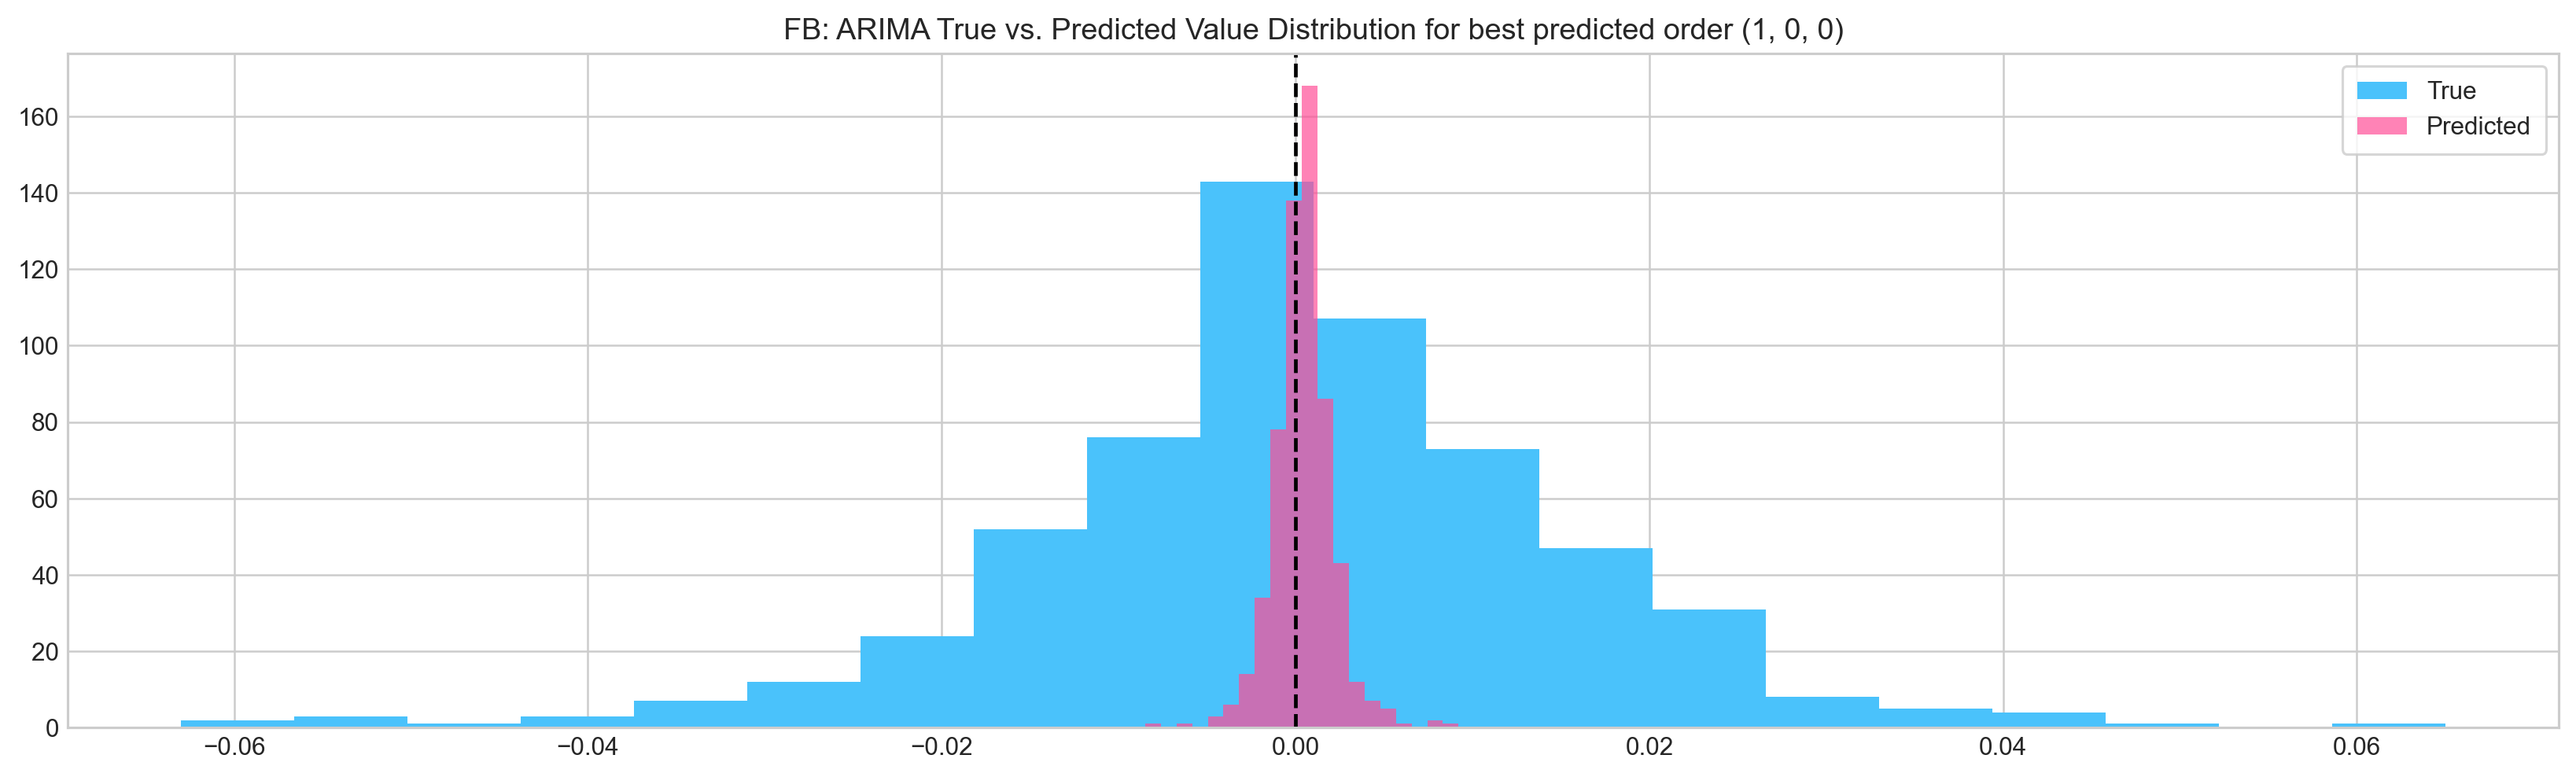

In [19]:
plt.figure(figsize=(18,5))
plt.hist(stocks[ticker.lower()][test_600:last_600].reset_index().Return, 
         bins=num_bins, label='True', facecolor=lightblue)
plt.hist(all_predictions[best_order], 
         bins=num_bins, label='Predicted', color=pinkyred, alpha=.7)
plt.axvline(0,c='k',ls='--')

plt.title(f"{ticker.upper()}: ARIMA True vs. Predicted Value Distribution for best predicted order {best_order}")
plt.legend(frameon=True,loc=1, ncol=1,fontsize=10,borderpad=.6)
plt.show()

### Interpret via Confusion Matrix

In [20]:
Binary = lambda data: [1 if x > 0 else 0 for x in data]

test_binary = Binary(stocks[ticker.lower()][test_600:last_600].reset_index().Return)
train_binary = Binary(all_predictions[best_order])

tn, fp, fn, tp = confusion_matrix(test_binary, train_binary).ravel()
accuracy = accuracy_score(test_binary, train_binary)

print(f"True Positive and Negative: {tp + tn}")
print(f"False Positive and Negative: {fp + fn}")
print(f"Accuracy: {round(accuracy*100, 5)}%")

True Positive and Negative: 317
False Positive and Negative: 283
Accuracy: 52.83333%
